Source
- Scraping Twitter: https://github.com/JustAnotherArchivist/snscrape/tree/master/snscrape
- SNScrape + Tweepy: https://medium.com/@jcldinco/downloading-historical-tweets-using-tweet-ids-via-snscrape-and-tweepy-5f4ecbf19032
- Tweet Preprocessing: https://www.kaggle.com/sreejiths0/efficient-tweet-preprocessing
- Sentiment Analysis: https://medium.com/better-programming/twitter-sentiment-analysis-15d8892c0082


## Bitcoin

In [2]:
from newsapi_help_func import *
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import json
from collections import Counter
from gensim.parsing.preprocessing import remove_stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re, string, unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
# nltk.download
# nltk.download('wordnet')
# nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
# !pip install ekphrasis
# !pip install tweet-preprocessor
import preprocessor as p
import tweepy

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

#For Sentiment Analysis
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/ridwan/Documents/DataScience/Metis/Metis_Projects/Project_04/newsapi_help_func.py:98: DeprecationWarning: invalid escape sequence \w
  alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/nltk/decorators.py:67: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  signature = inspect.formatargspec(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Pytho

In [41]:
!snscrape --max-results 2000 twitter-hashtag Bitcoin > bitcoin_2000.json

def json_to_csv(file_name):
    """
    Takes in json file and writes it into a csv file of the same name.
    """
    file_name = str(file_name)
    table = []
    with open((file_name+'.json'), 'r', encoding="utf8") as f:
        for line in f:
            table.append(json.loads(line))
    pd.DataFrame.from_records(table).to_csv(file_name+'.csv')

btc = json_to_csv('bitcoin_2000')

In [28]:
# !snscrape twitter-search  "#Bitcoin since:2020-11-01 until: 2020-11-02 max: 100" > btc_tweets_daily.txt
!snscrape --max-results 100 twitter-hashtag bitcoin "since: 2020-11-01 until: 2020-11-02"

usage: snscrape [-h] [--version] [-v] [--dump-locals] [--retry N] [-n N]
                [-f FORMAT] [--since DATETIME]
                {telegram-channel,vkontakte-user,googleplus-user,facebook-user,facebook-group,gab-user,gab-user-comments,gab-user-media,twitter-search,twitter-thread,twitter-list-members,instagram-user,instagram-hashtag,instagram-location,twitter-user,twitter-hashtag,twitter-list-posts}
                ...
snscrape: error: unrecognized arguments: since: 2020-11-01 until: 2020-11-02


In [ ]:
!snscrape twitter-search  "#Bitcoin since:2020-10-01 until: 2020-11-01" > bitcoin_tweets.txt

API Keys from Twitter Developer Account

In [3]:
consumer_key = "zB47sntXHX5qOLEkmuekKKlQd" 
consumer_secret = "IErfVGx6JiSgz2tTI5tVx4V5pB1Fofkj5yQIGihBnVt6JDWSd7" 
access_token = "AAAAAAAAAAAAAAAAAAAAAHykJQEAAAAAoJbCd66XTyca79rpkZEYU5yEFnE%3Dz3gcwG12uixSB2GYjhrR0YiyhquIkKvq1EbL0WTHtv93GBQEMX" 
# access_token_secret = "NNNNNNNNNNNNNNNNNNNNNNNNN"
auth = tweepy.OAuthHandler(consumer_key, consumer_secret) 
# auth.set_access_token(access_token, access_token_secret)
# auth.set_access_token(access_token)
api = tweepy.API(auth)

 Open .txt or .json using pandas.read_json or pandas.read_csv

In [4]:
tweet_url = pd.read_csv("bitcoin_tweets.txt", index_col= None, header = None, names = ["links"])
tweet_url.head()

,links
0,https://twitter.com/JoaoDMendes/status/1322689...
1,https://twitter.com/Z06Z07/status/132268980142...
2,https://twitter.com/PoisonI96460421/status/132...
3,https://twitter.com/CryptoWatchBot/status/1322...
4,https://twitter.com/planethardmoney/status/132...


 Extract tweet_id using .split function

In [5]:
af = lambda x: x["links"].split("/")[-1]
tweet_url['id'] = tweet_url.apply(af, axis=1)
tweet_url.head()

,links,id
0,https://twitter.com/JoaoDMendes/status/1322689...,1322689810381840385
1,https://twitter.com/Z06Z07/status/132268980142...,1322689801422696450
2,https://twitter.com/PoisonI96460421/status/132...,1322689799975653376
3,https://twitter.com/CryptoWatchBot/status/1322...,1322689779755032577
4,https://twitter.com/planethardmoney/status/132...,1322689752978624513


Convert tweet_url Series into list

In [6]:
ids = tweet_url['id'].tolist()

Issue looping through all ids, the API is giving an error. Therefore, process the ids by batch or chunks

In [7]:
total_count = len(ids)
chunks = (total_count - 1) // 50 + 1

Create function that would extract all elements that we need from the tweet (username, date and the tweet). Add hashtags???

In [8]:
def fetch_tw(ids):
    list_of_tw_status = api.statuses_lookup(ids, tweet_mode= "extended")
    empty_data = pd.DataFrame()
    for status in list_of_tw_status:
            tweet_elem = {"tweet_id": status.id,
                     "screen_name": status.user.screen_name,
                     "tweet":status.full_text,
                     "date":status.created_at}
            empty_data = empty_data.append(tweet_elem, ignore_index = True)
    empty_data.to_csv("bitcoin_tweets.csv", mode="a")

Create another for loop to loop into our batches while processing 50 entries every loop. (That felt like a tongue twister)

In [54]:
for i in range(chunks):
        batch = ids[i*50:(i+1)*50]
        result = fetch_tw(batch)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
df_tweets = pd.read_csv('btc_tweets.csv',
                 lineterminator='\n')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
df_tweets

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,date,screen_name,tweet,tweet_id
0,0.0,2020-10-31 23:58:52,Sarah85381260,Yworld Finance Airdrop is now Live🚀💰🏆\n\nClick...,1.3226895270187622e+18
1,1.0,2020-10-31 23:59:40,TraderKoz,What are you doing when #Bitcoin makes a new ATH?,1.3226897280182272e+18
2,2.0,2020-10-31 23:57:38,Solipsist18,#Bitcoin: BTC-USD ( $BTC-USD) UP 2.1721%! Last...,1.3226892163425935e+18
3,3.0,2020-10-31 23:58:01,Yayaya18948871,Royal Defi Airdrop is now Live🚀💰🏆\n\nClick on ...,1.3226893124213391e+18
4,4.0,2020-10-31 23:58:35,k_filippop,@BitcoinWhaIe #bitcoin,1.322689456642687e+18
...,...,...,...,...,...
15265,45.0,2020-10-31 10:53:04,D40five,@ModernInvest Happy #Bitcoin Birthday TMI.!!,1.3224917728330588e+18
15266,46.0,2020-10-31 10:52:01,dabildor,Ücretsiz bitcoin kazanmak ister misiniz? Telef...,1.3224915110875013e+18
15267,47.0,2020-10-31 10:54:36,arcbtc,Happy #bitcoin whitepaper day all!\n🤩🚀🌑\nhttps...,1.322492158943875e+18
15268,48.0,2020-10-31 10:54:42,didar_bekbau,Happy Whitepaper Day all my #Bitcoin fam! 🎉🎉🎉,1.3224921874483978e+18


In [5]:
df_tweets.count()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0     14971
date           15270
screen_name    15270
tweet          15270
tweet_id       15270
dtype: int64

## Tweet Preprocessing 
Since we are dealing with tweets in this competition, we need to do specific tweet text cleaning along with normal text pre-processing. A tweet may contain:
- URL's
- Mentions
- Hashtags
- Emojis
- Smileys
- Spefic words etc.

To clean the tweet , we can use a python library tweet-preprocessor instead of writing the cleaning logic ourself.

Source: https://www.kaggle.com/sreejiths0/efficient-tweet-preprocessing

Dropping duplicates and NaN from the dataframe

In [6]:
df_tweets = df_tweets.dropna()
df_tweets = df_tweets.drop_duplicates()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
df_tweets.count()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0     14971
date           14971
screen_name    14971
tweet          14971
tweet_id       14971
dtype: int64

Seperating hashtags into seperate column

In [8]:
df_tweets['hashtag'] = df_tweets['tweet'].apply(lambda x: re.findall(r"#(\w+)", x))
df_tweets

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,date,screen_name,tweet,tweet_id,hashtag
0,0.0,2020-10-31 23:58:52,Sarah85381260,Yworld Finance Airdrop is now Live🚀💰🏆\n\nClick...,1.3226895270187622e+18,"[Airdrop, Airdrops, blockchain, cryptocurrency..."
1,1.0,2020-10-31 23:59:40,TraderKoz,What are you doing when #Bitcoin makes a new ATH?,1.3226897280182272e+18,[Bitcoin]
2,2.0,2020-10-31 23:57:38,Solipsist18,#Bitcoin: BTC-USD ( $BTC-USD) UP 2.1721%! Last...,1.3226892163425935e+18,"[Bitcoin, Crypto, MasterMetals]"
3,3.0,2020-10-31 23:58:01,Yayaya18948871,Royal Defi Airdrop is now Live🚀💰🏆\n\nClick on ...,1.3226893124213391e+18,"[Airdrop, Airdrops, blockchain, cryptocurrency..."
4,4.0,2020-10-31 23:58:35,k_filippop,@BitcoinWhaIe #bitcoin,1.322689456642687e+18,[bitcoin]
...,...,...,...,...,...,...
15265,45.0,2020-10-31 10:53:04,D40five,@ModernInvest Happy #Bitcoin Birthday TMI.!!,1.3224917728330588e+18,[Bitcoin]
15266,46.0,2020-10-31 10:52:01,dabildor,Ücretsiz bitcoin kazanmak ister misiniz? Telef...,1.3224915110875013e+18,"[Bitcoin, BTC, altcoin, kriptopara, XRP, Airdr..."
15267,47.0,2020-10-31 10:54:36,arcbtc,Happy #bitcoin whitepaper day all!\n🤩🚀🌑\nhttps...,1.322492158943875e+18,[bitcoin]
15268,48.0,2020-10-31 10:54:42,didar_bekbau,Happy Whitepaper Day all my #Bitcoin fam! 🎉🎉🎉,1.3224921874483978e+18,[Bitcoin]


Apply tweet preprocessing first. Defining a preprocess function and using pandas apply to apply it on each value of 'text'. 

Preprocessing:
- Lowercasing
- Punctuation Removal
- Replace extra white spaces
- Stopwords removal
- For stop word removal , i have used gensim library

In [9]:
def preprocess_tweet(row):
    text = row['tweet']
    text = p.clean(text)
    text = remove_stopwords(text)
    return text

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
df_tweets['tweet'] = df_tweets.apply(preprocess_tweet, axis=1)
df_tweets['tweet'] = df_tweets['tweet'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \s
<ipython-input-10-fe42addc308c>:2: DeprecationWarning: invalid escape sequence \w
  df_tweets['tweet'] = df_tweets['tweet'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')
<ipython-input-10-fe42addc308c>:2: DeprecationWarning: invalid escape sequence \s
  df_tweets['tweet'] = df_tweets['tweet'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')


In [11]:
df_tweets.head()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,date,screen_name,tweet,tweet_id,hashtag
0,0.0,2020-10-31 23:58:52,Sarah85381260,yworld finance airdrop liveclick link particip...,1.3226895270187622e+18,"[Airdrop, Airdrops, blockchain, cryptocurrency..."
1,1.0,2020-10-31 23:59:40,TraderKoz,what makes new ath,1.3226897280182272e+18,[Bitcoin]
2,2.0,2020-10-31 23:57:38,Solipsist18,btc usd btc usd up last,1.3226892163425935e+18,"[Bitcoin, Crypto, MasterMetals]"
3,3.0,2020-10-31 23:58:01,Yayaya18948871,royal defi airdrop liveclick link participate ...,1.3226893124213391e+18,"[Airdrop, Airdrops, blockchain, cryptocurrency..."
4,4.0,2020-10-31 23:58:35,k_filippop,,1.322689456642687e+18,[bitcoin]


Everything seems cleaned up so now we can move onto Sentiment Analysis.

## Sentiment Analysis

The functions called will add the tweets’ subjectivity and polarity into two columns in the DataFrame. 
- getSubjectivity function: How subjective/opinionated the text is 
    - Score of 0 is fact
    - Score of +1 is very much an opinion 
- getPolarity: How positive or negative the text is
    - Score of -1 is the highest negative score
    - Score of +1 is the highest positive score

Source: https://medium.com/better-programming/twitter-sentiment-analysis-15d8892c0082

In [12]:
# Create a function to get the subjectivity
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
df_tweets['Subjectivity'] = df_tweets['tweet'].apply(getSubjectivity)
df_tweets['Polarity'] = df_tweets['tweet'].apply(getPolarity)

# Show the new dataframe with columns 'Subjectivity' & 'Polarity'
df_tweets

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,date,screen_name,tweet,tweet_id,hashtag,Subjectivity,Polarity
0,0.0,2020-10-31 23:58:52,Sarah85381260,yworld finance airdrop liveclick link particip...,1.3226895270187622e+18,"[Airdrop, Airdrops, blockchain, cryptocurrency...",0.900000,0.600000
1,1.0,2020-10-31 23:59:40,TraderKoz,what makes new ath,1.3226897280182272e+18,[Bitcoin],0.454545,0.136364
2,2.0,2020-10-31 23:57:38,Solipsist18,btc usd btc usd up last,1.3226892163425935e+18,"[Bitcoin, Crypto, MasterMetals]",0.066667,0.000000
3,3.0,2020-10-31 23:58:01,Yayaya18948871,royal defi airdrop liveclick link participate ...,1.3226893124213391e+18,"[Airdrop, Airdrops, blockchain, cryptocurrency...",0.900000,0.600000
4,4.0,2020-10-31 23:58:35,k_filippop,,1.322689456642687e+18,[bitcoin],0.000000,0.000000
...,...,...,...,...,...,...,...,...
15265,45.0,2020-10-31 10:53:04,D40five,happy birthday tmi,1.3224917728330588e+18,[Bitcoin],1.000000,0.800000
15266,46.0,2020-10-31 10:52:01,dabildor,cretsiz bitcoin kazanmak ister misiniz telefon...,1.3224915110875013e+18,"[Bitcoin, BTC, altcoin, kriptopara, XRP, Airdr...",0.000000,0.000000
15267,47.0,2020-10-31 10:54:36,arcbtc,happy whitepaper day all you ve bob gt 14k sat...,1.322492158943875e+18,[bitcoin],1.000000,0.800000
15268,48.0,2020-10-31 10:54:42,didar_bekbau,happy whitepaper day fam,1.3224921874483978e+18,[Bitcoin],1.000000,0.800000


Let's observe how well the sentiments are distributed by plotting the common words in a word clouds.
- Word cloud (also known as text clouds or tag clouds) is a visualization, the more a specific word appears in the text, the bigger and bolder it appears in the word cloud.

It looks like the words "participate" and "amazing" appear a lot for Bitcoins past 14,000+ tweets.

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


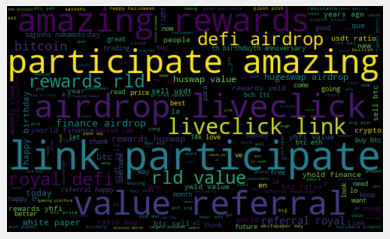

In [13]:
# word cloud visualization and potentially combine hashtags? 
allWords = ' '.join([twts for twts in df_tweets['tweet']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)


plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Function below computes the negative (-1), neutral (0), and positive (+1) analysis, and adds it to a new column called Analysis

In [14]:
# Create a function to compute negative (-1), neutral (0) and positive (+1) analysis
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

df_tweets['Analysis'] = df_tweets['Polarity'].apply(getAnalysis)
# Show the dataframe
df_tweets

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,date,screen_name,tweet,tweet_id,hashtag,Subjectivity,Polarity,Analysis
0,0.0,2020-10-31 23:58:52,Sarah85381260,yworld finance airdrop liveclick link particip...,1.3226895270187622e+18,"[Airdrop, Airdrops, blockchain, cryptocurrency...",0.900000,0.600000,Positive
1,1.0,2020-10-31 23:59:40,TraderKoz,what makes new ath,1.3226897280182272e+18,[Bitcoin],0.454545,0.136364,Positive
2,2.0,2020-10-31 23:57:38,Solipsist18,btc usd btc usd up last,1.3226892163425935e+18,"[Bitcoin, Crypto, MasterMetals]",0.066667,0.000000,Neutral
3,3.0,2020-10-31 23:58:01,Yayaya18948871,royal defi airdrop liveclick link participate ...,1.3226893124213391e+18,"[Airdrop, Airdrops, blockchain, cryptocurrency...",0.900000,0.600000,Positive
4,4.0,2020-10-31 23:58:35,k_filippop,,1.322689456642687e+18,[bitcoin],0.000000,0.000000,Neutral
...,...,...,...,...,...,...,...,...,...
15265,45.0,2020-10-31 10:53:04,D40five,happy birthday tmi,1.3224917728330588e+18,[Bitcoin],1.000000,0.800000,Positive
15266,46.0,2020-10-31 10:52:01,dabildor,cretsiz bitcoin kazanmak ister misiniz telefon...,1.3224915110875013e+18,"[Bitcoin, BTC, altcoin, kriptopara, XRP, Airdr...",0.000000,0.000000,Neutral
15267,47.0,2020-10-31 10:54:36,arcbtc,happy whitepaper day all you ve bob gt 14k sat...,1.322492158943875e+18,[bitcoin],1.000000,0.800000,Positive
15268,48.0,2020-10-31 10:54:42,didar_bekbau,happy whitepaper day fam,1.3224921874483978e+18,[Bitcoin],1.000000,0.800000,Positive


Prints the positive tweets in ascending order. The most positive tweet is the #1 tweet.

In [15]:
# Printing positive tweets 
print('Printing positive tweets:\n')
j=1
sortedDF = df_tweets.sort_values(by=['Polarity']) #Sort the tweets
for i in range(0, sortedDF.shape[0] ):
    if( sortedDF['Analysis'][i] == 'Positive'):
        print(str(j) + ') '+ sortedDF['tweet'][i])
        print()
        j= j+1

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Printing positive tweets:

1) yworld finance airdrop liveclick link participate amazing rewards ywld value referral 

2) what makes new ath 

3) royal defi airdrop liveclick link participate amazing rewards rld value referral 

4) yworld finance airdrop liveclick link participate amazing rewards ywld value referral 

5) million number divisible numbers cosmic power propagate new consciousness value 

6) let s yfi holy kore hate uni farm inj xvs sxp fio easy bot kp3r surf yeld core pria kper orai fmta tens stacy nice prq pols stake ocean bond

7) happy birthday

8) this chart shows interesting phenomenon needs consecutive da

KeyError: 50

Prints the negative tweets in ascending order. The most negative tweet is the #1 tweet.

In [22]:
# Printing negative tweets  
print('Printing negative tweets:\n')
j=1
sortedDF = df_tweets.sort_values(by=['Polarity'],ascending=False) #Sort the tweets
for i in range(0, sortedDF.shape[0] ):
    if( sortedDF['Analysis'][i] == 'Negative'):
        print(str(j) + ') '+sortedDF['tweet'][i])
        print()
        j=j+1

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Printing negative tweets:

1) i play cashback the play higher rank cashback get my username user927014

2)  optimal portfolio past hours given return s level



KeyError: 50

### Fix statement below
Plot the polarity and subjectivity as a scatter plot. It looks like the majority of the tweets are positive, as many of the points are on the right side of the polarity at value 0.00.

In [24]:
# Plotting 
plt.figure(figsize=(8,6)) 
for i in range(0, df_tweets.shape[0]):
    plt.scatter(df_tweets["Polarity"][i], df_tweets["Subjectivity"][i], color='Blue') 
# plt.scatter(x,y,color)   
# plt.title('Sentiment Analysis') 
# plt.xlabel('Polarity') 
# plt.ylabel('Subjectivity') 
# plt.show()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Print the percentage of positive tweets. About 43.6% of the tweets are considered positive tweets.

In [25]:
# Print the percentage of positive tweets
ptweets = df_tweets[df_tweets.Analysis == 'Positive']
ptweets = ptweets['tweet']
ptweets

round( (ptweets.shape[0] / df_tweets.shape[0]) * 100 , 1)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


43.6

Print the percentage of negative tweets. About 5.2% of the tweets are considered negative tweets.

In [26]:
# Print the percentage of negative tweets
ntweets = df_tweets[df_tweets.Analysis == 'Negative']
ntweets = ntweets['tweet']
ntweets

round( (ntweets.shape[0] / df_tweets.shape[0]) * 100, 1)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5.2

In [27]:
# Show the value counts
df_tweets['Analysis'].value_counts()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Neutral     7655
Positive    6531
Negative     785
Name: Analysis, dtype: int64

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


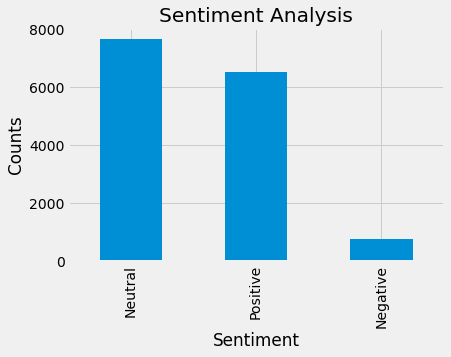

In [28]:
# Plotting and visualizing the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df_tweets['Analysis'].value_counts().plot(kind = 'bar')
plt.show()

In [29]:
from string import punctuation

# Text preprocessing steps - remove numbers, captial letters and punctuation
def preprocess_sentiment(df):
    alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
    punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

    df['tokens'] = df.tweet.map(alphanumeric).map(punc_lower)  

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:5: DeprecationWarning: invalid escape sequence \w
<>:5: DeprecationWarning: invalid escape sequence \w
<ipython-input-29-0d3071b6d7ff>:5: DeprecationWarning: invalid escape sequence \w
  alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)


In [30]:
preprocess_sentiment(df_tweets)
df_tweets

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,date,screen_name,tweet,tweet_id,hashtag,Subjectivity,Polarity,Analysis,tokens
0,0.0,2020-10-31 23:58:52,Sarah85381260,yworld finance airdrop liveclick link particip...,1.3226895270187622e+18,"[Airdrop, Airdrops, blockchain, cryptocurrency...",0.900000,0.600000,Positive,yworld finance airdrop liveclick link particip...
1,1.0,2020-10-31 23:59:40,TraderKoz,what makes new ath,1.3226897280182272e+18,[Bitcoin],0.454545,0.136364,Positive,what makes new ath
2,2.0,2020-10-31 23:57:38,Solipsist18,btc usd btc usd up last,1.3226892163425935e+18,"[Bitcoin, Crypto, MasterMetals]",0.066667,0.000000,Neutral,btc usd btc usd up last
3,3.0,2020-10-31 23:58:01,Yayaya18948871,royal defi airdrop liveclick link participate ...,1.3226893124213391e+18,"[Airdrop, Airdrops, blockchain, cryptocurrency...",0.900000,0.600000,Positive,royal defi airdrop liveclick link participate ...
4,4.0,2020-10-31 23:58:35,k_filippop,,1.322689456642687e+18,[bitcoin],0.000000,0.000000,Neutral,
...,...,...,...,...,...,...,...,...,...,...
15265,45.0,2020-10-31 10:53:04,D40five,happy birthday tmi,1.3224917728330588e+18,[Bitcoin],1.000000,0.800000,Positive,happy birthday tmi
15266,46.0,2020-10-31 10:52:01,dabildor,cretsiz bitcoin kazanmak ister misiniz telefon...,1.3224915110875013e+18,"[Bitcoin, BTC, altcoin, kriptopara, XRP, Airdr...",0.000000,0.000000,Neutral,cretsiz bitcoin kazanmak ister misiniz telefon...
15267,47.0,2020-10-31 10:54:36,arcbtc,happy whitepaper day all you ve bob gt 14k sat...,1.322492158943875e+18,[bitcoin],1.000000,0.800000,Positive,happy whitepaper day all you ve bob gt satur...
15268,48.0,2020-10-31 10:54:42,didar_bekbau,happy whitepaper day fam,1.3224921874483978e+18,[Bitcoin],1.000000,0.800000,Positive,happy whitepaper day fam


In [31]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_tweets['tokens'], df_tweets['Analysis'], test_size=0.3, random_state=42)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# The first document-term matrix has default Count Vectorizer values - counts of unigrams
cv1 = CountVectorizer(stop_words='english')

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

X_train_cv1_df = pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names()).head()
X_train_cv1_df

#these words need to be removed!!!

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,aadaki,aaj,aan,aannnnnd,aapl,aarsa,aave,aavebuy,ab,abacus,...,zulauf,zum,zur,zurck,zurich,zustzliche,zut,zwei,zwischenzeitliches,zwlften
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# The second document-term matrix has both unigrams and bigrams, and indicators instead of counts
cv2 = CountVectorizer(ngram_range=(1,2), binary=True, stop_words='english')

X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2  = cv2.transform(X_test)

X_train_cv2_df = pd.DataFrame(X_train_cv2.toarray(), columns=cv2.get_feature_names()).head()
X_train_cv2_df

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,aadaki,aadaki linkin,aadaki linkten,aaj,aaj ka,aan,aan andere,aan ene,aan hun,aan zoals,...,zustzliche,zustzliche ordergebhren,zut,zut kore,zwei,zwei monaten,zwischenzeitliches,zwischenzeitliches tief,zwlften,zwlften geburtstag
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Classifying Using Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model to use
lr = LogisticRegression()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
# Train the first model
lr.fit(X_train_cv1, y_train)
y_pred_cv1 = lr.predict(X_test_cv1)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
# Train the second model
lr.fit(X_train_cv2, y_train)
y_pred_cv2 = lr.predict(X_test_cv2)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Keeps saying too many values to unpack for cells below

In [37]:
# The heat map for the first logistic regression model
cm1 = conf_matrix(y_test, y_pred_cv1)

In [36]:
# The heat map for the second logistic regression model
cm2 = conf_matrix(y_test, y_pred_cv2)

In [35]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm1, cm2)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg1', 'LogReg2']
results

### Classifying Using Naive Bayes

In [39]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

# Fit the first Naive Bayes model

mnb = MultinomialNB()
mnb.fit(X_train_cv1, y_train)

y_pred_cv1_nb = mnb.predict(X_test_cv1)

In [40]:
# Fit the second Naive Bayes model

bnb = BernoulliNB()
bnb.fit(X_train_cv2, y_train)

y_pred_cv2_nb = bnb.predict(X_test_cv2)

Same issue as above. Too many values to unpack

In [43]:
# Here's the heat map for the first Naive Bayes model
cm3 = conf_matrix(y_test, y_pred_cv1_nb)

In [44]:
# Here's the heat map for the second Naive Bayes model
cm4 = conf_matrix(y_test, y_pred_cv2_nb)

In [46]:
# Compile all of the error metrics into a dataframe for comparison
results_nb = pd.DataFrame(list(zip(cm3, cm4)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_nb.columns = ['NB1', 'NB2']
results_nb

results = pd.concat([results, results_nb], axis=1)
results

### TF-IDF

In [47]:
# Create TF-IDF versions of the Count Vectorizers created earlier in the exercise
tfidf1 = TfidfVectorizer(stop_words='english')
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_test_tfidf1  = tfidf1.transform(X_test)

pd.DataFrame(X_train_tfidf1.toarray(), columns=tfidf1.get_feature_names()).head()
#potentially drop values with 0.0 values?? 

,aadaki,aaj,aan,aannnnnd,aapl,aarsa,aave,aavebuy,ab,abacus,...,zulauf,zum,zur,zurck,zurich,zustzliche,zut,zwei,zwischenzeitliches,zwlften
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
tfidf2 = TfidfVectorizer(ngram_range=(1,2), binary=True, stop_words='english')
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2  = tfidf2.transform(X_test)

pd.DataFrame(X_train_tfidf2.toarray(), columns=tfidf2.get_feature_names()).head()

,aadaki,aadaki linkin,aadaki linkten,aaj,aaj ka,aan,aan andere,aan ene,aan hun,aan zoals,...,zustzliche,zustzliche ordergebhren,zut,zut kore,zwei,zwei monaten,zwischenzeitliches,zwischenzeitliches tief,zwlften,zwlften geburtstag
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
# Fit the first logistic regression on the TF-IDF data
lr.fit(X_train_tfidf1, y_train)
y_pred_tfidf1_lr = lr.predict(X_test_tfidf1)
cm5 = conf_matrix(y_test, y_pred_tfidf1_lr)

In [ ]:
# Fit the second logistic regression on the TF-IDF data
lr.fit(X_train_tfidf2, y_train)
y_pred_tfidf2_lr = lr.predict(X_test_tfidf2)
cm6 = conf_matrix(y_test, y_pred_tfidf2_lr)

In [ ]:
# Fit the first Naive Bayes model on the TF-IDF data
mnb.fit(X_train_tfidf1.toarray(), y_train)
y_pred_tfidf1_nb = mnb.predict(X_test_tfidf1)
cm7 = conf_matrix(y_test, y_pred_tfidf1_nb)

In [ ]:
# Fit the second Naive Bayes model on the TF-IDF data
bnb.fit(X_train_tfidf2.toarray(), y_train)
y_pred_tfidf2_nb = bnb.predict(X_test_tfidf2)
cm8 = conf_matrix(y_test, y_pred_tfidf2_nb)

In [ ]:
# Compile all of the error metrics into a dataframe for comparison
results_tf = pd.DataFrame(list(zip(cm5, cm6, cm7, cm8)))
results_tf = results_tf.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_tf.columns = ['LR1-TFIDF', 'LR2-TFIDF', 'NB1-TFIDF', 'NB2-TFIDF']
results_tf

results = pd.concat([results, results_tf], axis=1)
results

## Topic Modeling with Matrix Factorization

### Latent Semantic Analysis (LSA)

Sklearn's TruncatedSVD is designed to perform singular value decomposition on a count vectorizer or TF-IDF vectorizer object. Read up on the [documentation](https://scikit-learn.org/stable/modules/decomposition.html), which also discusses NMF and LDA.

> TruncatedSVD is very similar to PCA, but differs in that the matrix *X* does not need to be centered. When the columnwise (per-feature) means of *X* are subtracted from the feature values, truncated SVD on the resulting matrix is equivalent to PCA. In practical terms, this means that the TruncatedSVD transformer accepts scipy.sparse matrices without the need to densify them, as densifying may fill up memory even for medium-sized document collections.

> While the TruncatedSVD transformer works with any feature matrix, using it on tf–idf matrices is recommended over raw frequency counts in an LSA/document processing setting. In particular, sublinear scaling and inverse document frequency should be turned on (sublinear_tf=True, use_idf=True) to bring the feature values closer to a Gaussian distribution, compensating for LSA’s erroneous assumptions about textual data.

In [37]:
# Latent Semantic Analysis (LSA) is just another name for Singular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
lsa = TruncatedSVD(2)
btc_doc_topic = lsa.fit_transform(X_train_cv1)
lsa.explained_variance_ratio_

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0.16055488, 0.03218303])

The U matrix shows us the 2 resulting topics, and the terms that are associated with each topic. In this case:
- Component 1 (topic 1) seems to be about ...
- Component 2 (topic 2) seems to be about ...

In [38]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2"],
             columns = cv1.get_feature_names())
topic_word

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,aadaki,aaj,aan,aannnnnd,aapl,aarsa,aave,aavebuy,ab,abacus,...,zulauf,zum,zur,zurck,zurich,zustzliche,zut,zwei,zwischenzeitliches,zwlften
component_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
display_topics(lsa, cv1.get_feature_names(), 5)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

Topic  0
link, value, airdrop, amazing, participate

Topic  1
btc, sell, ratio, usdt, buy


The Vt matrix shows us the documents we started with, and how each document is made up of the # resulting topics. In this case:
- The first ### documents seem to be about ...
- The last ### documents seem to be about ...

In [41]:
Vt = pd.DataFrame(btc_doc_topic.round(5),
             index = X_train,
             columns = ["component_1","component_2" ])
Vt

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,component_1,component_2
tokens,,
bsv vs ltc,0.00190,0.04589
happy th birthday bitcoin oct set motion revolution finance learn profit huge trend x,0.05273,0.21667
sure the users retweet comment receive mt perfect friend trust admits,0.00039,0.00713
happy th anniversary satoshi nakamoto s white paper our passion borderless financial future continues,0.00161,0.10581
market update the price currently btc view coin here,0.00272,0.90574
...,...,...
im fortunate high profile amp trading group members some guys trade btc amp funds lot liquidated today ill understand traders carelessly try trade corrective waves,0.00470,0.89949
poder del seor america,0.00003,0.01538
wow big giveaway sirthanks giveaway hope win life go joinn,0.00017,0.01668


Looking at cosine similarity, you can see that two documents both high in component 2 will have a similarity of 1, and two documents high in different components will have a similarity of 0.

In [42]:
cosine_similarity(Vt)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[1.        , 0.98059059, 0.99991203, ..., 0.99951369, 0.99956234,
        0.99924269],
       [0.98059059, 1.        , 0.98310493, ..., 0.97399974, 0.97436128,
        0.97221887],
       [0.99991203, 0.98310493, 1.        , ..., 0.99901215, 0.99908203,
        0.99863868],
       ...,
       [0.99951369, 0.97399974, 0.99901215, ..., 1.        , 0.99999872,
        0.99997011],
       [0.99956234, 0.97436128, 0.99908203, ..., 0.99999872, 1.        ,
        0.99995644],
       [0.99924269, 0.97221887, 0.99863868, ..., 0.99997011, 0.99995644,
        1.        ]])

In [43]:
cos_dtm = cosine_similarity(X_train_cv1_df).round(2)
cos_dtm

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.16, 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.16, 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  ]])

### Non-Negative Matrix Factorization (NMF)

In this example, we are going to start with 6 documents that contain many unique words (or features). The goal is to reduce those words down into 2 topics, so that each document can be represented as some combination of the 2 topics. We will be using NMF this time around.

In [44]:
nmf_model = NMF(2)
btc_nmf_doc_topic = nmf_model.fit_transform(X_train_cv1)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The W matrix shows us the 2 resulting topics, and the terms that are associated with each topic. In this case:
- Component 1 (topic 1) seems to be about ###
- Component 2 (topic 2) seems to be about ###

In [45]:
topic_word_nmf = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2"],
             columns = cv1.get_feature_names())
topic_word_nmf

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,aadaki,aaj,aan,aannnnnd,aapl,aarsa,aave,aavebuy,ab,abacus,...,zulauf,zum,zur,zurck,zurich,zustzliche,zut,zwei,zwischenzeitliches,zwlften
component_1,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,...,0.0,0.000,0.0,0.0,0.0,0.0,0.001,0.0,0.0,0.0
component_2,0.003,0.0,0.0,0.0,0.0,0.002,0.002,0.008,0.0,0.0,...,0.0,0.003,0.0,0.0,0.0,0.0,0.002,0.0,0.0,0.0


In [46]:
display_topics(nmf_model, cv1.get_feature_names(), 10)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

Topic  0
link, value, airdrop, amazing, participate, referral, rewards, liveclick, defi, rld

Topic  1
btc, sell, ratio, usdt, buy, bitcoin, eth, usd, price, mxn


The H matrix shows us the documents we started with, and how each document is made up of the 2 resulting topics. In this case:
- The first document seems to be about ...
- The last document seems to be about ...
- Everything in between is a combination of the two

In [47]:
H = pd.DataFrame(btc_nmf_doc_topic.round(5),
             index = X_train,
             columns = ["component_1","component_2" ])
H

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,component_1,component_2
tokens,,
bsv vs ltc,0.00012,0.00602
happy th birthday bitcoin oct set motion revolution finance learn profit huge trend x,0.00432,0.02834
sure the users retweet comment receive mt perfect friend trust admits,0.00003,0.00094
happy th anniversary satoshi nakamoto s white paper our passion borderless financial future continues,0.00004,0.01390
market update the price currently btc view coin here,0.00000,0.11904
...,...,...
im fortunate high profile amp trading group members some guys trade btc amp funds lot liquidated today ill understand traders carelessly try trade corrective waves,0.00000,0.11821
poder del seor america,0.00000,0.00202
wow big giveaway sirthanks giveaway hope win life go joinn,0.00000,0.00219


In [48]:
# Set categories
categories = ['bitcoin', 'paypal', 'crypto']

# Download the training subset of the 20 NG dataset, with headers, footers, quotes removed
# Only keep docs from the 6 categories above
ng_train = X_train_cv1_df(subset='train', categories=categories, 
                                      remove=('headers', 'footers', 'quotes'))

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: 'DataFrame' object is not callable

## Topic Modeling with sklearn and pyLDAvis

Adapted from [the official pyLDAvis repo demo](https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb).

We'll try out [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) on the [20 Newsgroups dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html) with some simple preprocessing.

In [49]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(X_train)
print(dtm_tf.shape)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
(10479, 1056)


In [50]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(X_train)
print(dtm_tfidf.shape)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
(10479, 1056)


### Fit the Latent Dirichlet Allocation models

In [51]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tf.fit(dtm_tf)

# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tfidf.fit(dtm_tfidf)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(n_components=20, random_state=0)

## pyLDAvis

Recall the # categories we extracted:

* ...
* ...

Let's use [pyLDAvis](http://bl.ocks.org/AlessandraSozzi/raw/ce1ace56e4aed6f2d614ae2243aab5a5/) to see our topics, and to see if they match up with our expectations.

* The left panel visualizes the topics as circles in the two-dimensional plane whose centres are determined by computing the Jensen–Shannon divergence between topics, and then by using [multidimensional scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling) to project the inter-topic distances onto two dimensions. Each topic’s overall prevalence is encoded using the areas of the circles.

* The right panel depicts a horizontal bar chart whose bars represent the individual terms that are the most useful for interpreting the currently selected topic on the left. A pair of overlaid bars represent both the corpus-wide frequency of a given term as well as the topic-specific frequency of the term.

* The λ slider allows to rank the terms according to term relevance. By default, the terms of a topic are ranked in decreasing order according their topic-specific probability ( λ = 1 ). Moving the slider allows to adjust the rank of terms based on much discriminatory (or "relevant") are for the specific topic. The suggested “optimal” value of λ is 0.6. [Small values of λ (near 0) highlight potentially rare, but exclusive terms for the selected topic, and large values of λ (near 1) highlight frequent, but not necessarily exclusive, terms for the selected topic.](http://www.kennyshirley.com/LDAvis/)

In [52]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.437605 -0.047852       1        1  30.171075
3     -0.089984 -0.158727       2        1   5.620030
10    -0.101248 -0.169947       3        1   4.829708
18    -0.075727 -0.089323       4        1   4.677333
6      0.060900  0.274812       5        1   4.412418
5     -0.046778  0.189985       6        1   4.382299
11     0.419497 -0.059352       7        1   4.347338
19    -0.046906 -0.104272       8        1   4.282253
17     0.000285  0.328530       9        1   4.040708
1     -0.128091 -0.007887      10        1   3.890296
13    -0.112061  0.127555      11        1   3.719489
0     -0.116776 -0.028101      12        1   3.527248
8     -0.117306 -0.009538      13        1   3.519024
2     -0.017410  0.061071      14        1   3.479086
12    -0.067078  0.066935      15        1   3.340514
4     -0.107570 -0.132734      16        1   2.962935
15    -0.049365 -0.031464      17        1   2.742976
14    -0.059230 -0.101821      18        1   2.616958
7      0.010430 -0.049059      19        1   1.792989
9      0.206812 -0.058812      20        1   1.645322, topic_info=            Term         Freq        Total Category  logprob  loglift
972        value  1959.000000  1959.000000  Default  30.0000  30.0000
20       airdrop  1908.000000  1908.000000  Default  29.0000  29.0000
31       amazing  1903.000000  1903.000000  Default  28.0000  28.0000
652  participate  1883.000000  1883.000000  Default  27.0000  27.0000
761      rewards  1875.000000  1875.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
972        value    33.723557  1959.382077  Topic20  -3.3825   0.0450
520         link    12.372245  2088.071253  Topic20  -4.3852  -1.0213
229         days     2.604273    87.159395  Topic20  -5.9435   0.5966
743     referral     3.381251  1899.608093  Topic20  -5.6824  -2.2239
761      rewards     1.766560  1875.281572  Topic20  -6.3316  -2.8602

[920 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4        14  0.902629   according
5         4  0.824864     account
5        10  0.131978     account
6        10  0.202115  accumulate
6        18  0.134743  accumulate
...     ...       ...         ...
1051      7  0.991147      yworld
1052     17  0.972571         zil
1053      1  0.972208         ziz
1054      1  0.972208        zize
1055      4  0.940774      zombie

[1524 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 4, 11, 19, 7, 6, 12, 20, 18, 2, 14, 1, 9, 3, 13, 5, 16, 15, 8, 10])

The topics for our TFIDFVectorizer LDA also appear to match up with our newsgroups categories, though not as cleanly:

#### Change below!!!
* Topic 1: people (unclear)
* Topic 2: israel, jews ('talk.politics.mideast')
* Topic 3: space, NASA ('sci.space')
* Topic 4: files, graphics ('comp.graphics')
* Topic 5: games, baseball ('rec.sport.baseball')
* Topic 6: yankees, planetary (unclear)

Overall, it appears that with minimal text preprocessing, LDA was still able to extract the relevant topics from our corpus. It appears as though some miscellaneous terms are still floating around in our topics - additional text preprocessing, particularly stop word removal, is needed!

Let's revisit the CountVectorizer LDA model. We can adjust multidimensional scaling to get "cleaner" topic bubbles.

In [53]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='mmds')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.057692 -0.519525       1        1  30.171075
3      0.409740  0.070496       2        1   5.620030
10    -0.271088 -0.044771       3        1   4.829708
18    -0.331601 -0.229344       4        1   4.677333
6      0.303243 -0.310037       5        1   4.412418
5      0.151635 -0.209961       6        1   4.382299
11    -0.042345 -0.481901       7        1   4.347338
19     0.233256  0.407328       8        1   4.282253
17     0.423870  0.242396       9        1   4.040708
1     -0.054465  0.035869      10        1   3.890296
13     0.192022  0.011638      11        1   3.719489
0     -0.098764  0.364369      12        1   3.527248
8      0.127856  0.184771      13        1   3.519024
2     -0.280519  0.334771      14        1   3.479086
12     0.026175  0.447511      15        1   3.340514
4     -0.227537  0.159288      16        1   2.962935
15    -0.449941 -0.087883      17        1   2.742976
14    -0.440201  0.162595      18        1   2.616958
7      0.450810 -0.160928      19        1   1.792989
9     -0.179839 -0.376682      20        1   1.645322, topic_info=            Term         Freq        Total Category  logprob  loglift
972        value  1959.000000  1959.000000  Default  30.0000  30.0000
20       airdrop  1908.000000  1908.000000  Default  29.0000  29.0000
31       amazing  1903.000000  1903.000000  Default  28.0000  28.0000
652  participate  1883.000000  1883.000000  Default  27.0000  27.0000
761      rewards  1875.000000  1875.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
972        value    33.723557  1959.382077  Topic20  -3.3825   0.0450
520         link    12.372245  2088.071253  Topic20  -4.3852  -1.0213
229         days     2.604273    87.159395  Topic20  -5.9435   0.5966
743     referral     3.381251  1899.608093  Topic20  -5.6824  -2.2239
761      rewards     1.766560  1875.281572  Topic20  -6.3316  -2.8602

[920 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4        14  0.902629   according
5         4  0.824864     account
5        10  0.131978     account
6        10  0.202115  accumulate
6        18  0.134743  accumulate
...     ...       ...         ...
1051      7  0.991147      yworld
1052     17  0.972571         zil
1053      1  0.972208         ziz
1054      1  0.972208        zize
1055      4  0.940774      zombie

[1524 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 4, 11, 19, 7, 6, 12, 20, 18, 2, 14, 1, 9, 3, 13, 5, 16, 15, 8, 10])

In [54]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='tsne')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
16     -10.878068   10.538728       1        1  30.171075
3      -60.884026  -75.591820       2        1   5.620030
10      -2.336119  -53.289074       3        1   4.829708
18     -61.385319  -12.914634       4        1   4.677333
6      -28.737743  126.296997       5        1   4.412418
5        1.066606 -123.552811       6        1   4.382299
11      45.140720   -7.947869       7        1   4.347338
19    -140.795975  -98.530548       8        1   4.282253
17      61.531681  -83.240562       9        1   4.040708
1      -72.563057 -140.396881      10        1   3.890296
13      15.984491   63.578186      11        1   3.719489
0     -160.851624   68.945145      12        1   3.527248
8       85.961830   51.922935      13        1   3.519024
2      -99.020836  109.936348      14        1   3.479086
12    -176.764130   -8.681684      15        1   3.340514
4     -117.189880  -37.420200      16        1   2.962935
15     108.829918  -22.946203      17        1   2.742976
14      47.588097  121.934814      18        1   2.616958
7     -106.467834   30.176889      19        1   1.792989
9      -50.613804   59.328842      20        1   1.645322, topic_info=            Term         Freq        Total Category  logprob  loglift
972        value  1959.000000  1959.000000  Default  30.0000  30.0000
20       airdrop  1908.000000  1908.000000  Default  29.0000  29.0000
31       amazing  1903.000000  1903.000000  Default  28.0000  28.0000
652  participate  1883.000000  1883.000000  Default  27.0000  27.0000
761      rewards  1875.000000  1875.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
972        value    33.723557  1959.382077  Topic20  -3.3825   0.0450
520         link    12.372245  2088.071253  Topic20  -4.3852  -1.0213
229         days     2.604273    87.159395  Topic20  -5.9435   0.5966
743     referral     3.381251  1899.608093  Topic20  -5.6824  -2.2239
761      rewards     1.766560  1875.281572  Topic20  -6.3316  -2.8602

[920 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4        14  0.902629   according
5         4  0.824864     account
5        10  0.131978     account
6        10  0.202115  accumulate
6        18  0.134743  accumulate
...     ...       ...         ...
1051      7  0.991147      yworld
1052     17  0.972571         zil
1053      1  0.972208         ziz
1054      1  0.972208        zize
1055      4  0.940774      zombie

[1524 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 4, 11, 19, 7, 6, 12, 20, 18, 2, 14, 1, 9, 3, 13, 5, 16, 15, 8, 10])

## On your own...

- Look at different subsets of the 20newsgroups dataset  
- Try performing LDA on this data with gensim (see `additional_resources` subdirectory)
- Play with some of the preprocessing options and parameters for LDA, observe what happens
- See if you can use the resulting topic space to extract topic vectors
- How do your results look?
- Can you think of how you could cluster this data? (k-means lecture)